In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
from gpflow.utilities import print_summary, positive
plt.style.use('ggplot')
%matplotlib inline
import tensorflow as tf
import math
from tensorflow import math as tm
from sklearn import preprocessing
from tensorflow_probability import bijectors as tfb

PI = tf.constant(math.pi, dtype='float64')

# Replication of the paper by Lawrence et al., 2006

https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf

#### Probesets

The original paper restricted their interest to 5 known targets of p53: 
- DDB2 -------------- (probeset 203409_at)
- p21 ----------------- (probeset 202284_s_at) (alias p21CIP1, CDKN1A)
- SESN1/hPA26 -- (probeset 218346_s_at)
- BIK ----------------- (probeset 205780_at)
- TNFRSF10b ----- (probeset 209294_x_at, 209295_at, 210405_x_at)

In [2]:
with open('barenco_processed.tsv', 'r') as f:
    index = 0
    df = pd.read_csv(f, delimiter='\t', index_col=0)
display(df.head(5))
columns = ['H_ARP1-0h.3', 'H_ARP1-2h.3', 'H_ARP1-4h.3', 'H_ARP1-6h.3', 'H_ARP1-8h.3', 'H_ARP1-10h.3', 'H_ARP1-12h.3']

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,6,8,9,10,12,14,15,16,18,20,21,22,24,26,27,28,30,32,33,34,36,38,39,40,42,44,45,46,48,50,51,52,54,56,57,58,60,62,63,64,66,68,69,70,72,74,75,76,78,80,81,82,84,86,87,88,90,92,93,94,96,98,99,100,102,104,105,106,108,110,111,112,114,116,117,118,120,122,123,124,126) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,H_ARP1-0h,H_ARP1-0h.1,H_ARP1-0h.2,H_ARP1-0h.3,H_ARP1-0h.4,H_ARP1-0h.5,H_ARP1-2h,H_ARP1-2h.1,H_ARP1-2h.2,H_ARP1-2h.3,...,H_ARP3-10h.2,H_ARP3-10h.3,H_ARP3-10h.4,H_ARP3-10h.5,H_ARP3-12h,H_ARP3-12h.1,H_ARP3-12h.2,H_ARP3-12h.3,H_ARP3-12h.4,H_ARP3-12h.5
Scan REF,,,,,,,,,,,,,,,,,,,,,
Composite Element REF,Affymetrix:CHPProbeSetName,Affymetrix:CHPPairs,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,Affymetrix:CHPDetection,Affymetrix:CHPDetectionPvalue,Affymetrix:CHPProbeSetName,Affymetrix:CHPPairs,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,...,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,Affymetrix:CHPDetection,Affymetrix:CHPDetectionPvalue,Affymetrix:CHPProbeSetName,Affymetrix:CHPPairs,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,Affymetrix:CHPDetection,Affymetrix:CHPDetectionPvalue
AFFX-BioB-5_at,AFFX-BioB-5_at,20,20,131.7,Present,0.00039,AFFX-BioB-5_at,20,20,140.3,...,20,456.9,Present,0.00022,AFFX-BioB-5_at,20,20,410.1,Present,0.00017
AFFX-BioB-M_at,AFFX-BioB-M_at,20,20,260.6,Present,5.00E-05,AFFX-BioB-M_at,20,20,274.7,...,20,1210.7,Present,4.00E-05,AFFX-BioB-M_at,20,20,1102.9,Present,4.00E-05
AFFX-BioB-3_at,AFFX-BioB-3_at,20,20,142.7,Present,8.00E-05,AFFX-BioB-3_at,20,20,159.5,...,20,693.8,Present,5.00E-05,AFFX-BioB-3_at,20,20,560.1,Present,5.00E-05
AFFX-BioC-5_at,AFFX-BioC-5_at,20,20,348.8,Present,7.00E-05,AFFX-BioC-5_at,20,20,396.4,...,20,1324.1,Present,4.00E-05,AFFX-BioC-5_at,20,20,1052.6,Present,5.00E-05


In [3]:
assert df[df.duplicated()].size == 0

### Probeset Combination

TNFRSF10b has multiple probesets (probeset 209294_x_at, 209295_at, 210405_x_at) which should be combined.

It can be observed below that the log intensities have a similar pattern. Thus a popular way to combine is to take the average of the log intensities.

[8.8, 38.5, 61.2, 59.8, 60.6, 41.7, 22.1]
[34.2, 171.9, 220.3, 236.4, 302.5, 181.6, 152.9]
[5.8, 12.2, 53.6, 52.3, 67.6, 37.5, 23.7]


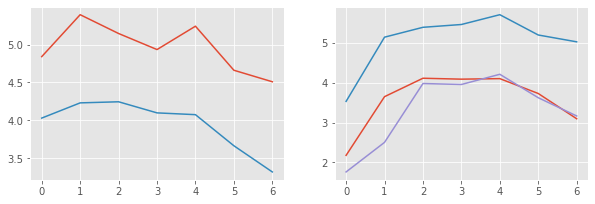

In [4]:
known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at', '209295_at']
genes = df[df.index.isin(known_target_genes)][columns]

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
p53 = df[df.index.isin(['211300_s_at', '201746_at'])][columns].astype(float)
for index, row in p53.iterrows():
    p53.loc[index] = np.log(list(row))
    plt.plot(list(row))

p53_mean = pd.Series(p53.mean(0), index=genes.columns, name='p53')

plt.subplot(2,2,2)
TNFRSF10b = df[df.index.isin(['209294_x_at', '209295_at', '210405_x_at'])][columns]
for index, row in TNFRSF10b.iterrows():
    print(list(row))
    TNFRSF10b.loc[index] = np.log(list(row))
    plt.plot(list(row))

TNFRSF10b_mean = pd.Series(TNFRSF10b.mean(0), index=genes.columns, name='TNFRSF10b')

In [5]:
genes.rename(index={
    '203409_at': 'DDB2', 
    '202284_s_at': 'p21',
    '218346_s_at': 'SESN1',
    '205780_at': 'BIK',
    '209295_at': 'TNFRSF10b'
}, inplace=True)

# genes = genes.append(TNFRSF10b_mean, ignore_index=False)
genes = genes.append(p53_mean, ignore_index=False).astype(np.float64)
#print(genes.loc[genes['Scan REF'] == pd.nan, 'Scan REF'])# = 'test'
display(genes)

,H_ARP1-0h.3,H_ARP1-2h.3,H_ARP1-4h.3,H_ARP1-6h.3,H_ARP1-8h.3,H_ARP1-10h.3,H_ARP1-12h.3
Scan REF,,,,,,,
p21,6.90000,175.400000,401.300000,289.200000,303.800000,157.300000,153.500000
DDB2,248.40000,723.100000,1059.000000,1328.200000,1471.400000,946.200000,952.000000
BIK,55.00000,161.200000,306.200000,354.300000,351.600000,170.900000,215.900000
TNFRSF10b,34.20000,171.900000,220.300000,236.400000,302.500000,181.600000,152.900000
SESN1,100.60000,209.100000,296.000000,314.900000,397.100000,209.500000,212.700000
p53,4.43458,4.811916,4.694975,4.515713,4.658209,4.162083,3.913238


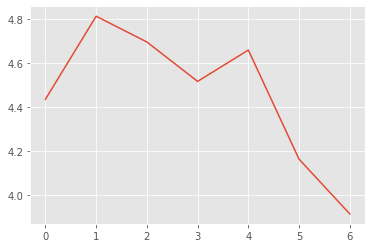

In [6]:
plt.plot(genes[genes.index == 'p53'].values[0])

### Scale data

In [7]:
num_genes = 5 #X.shape[1]
num_times = 7
scaler = preprocessing.StandardScaler()
Y = genes[genes.index != 'p53'].values.reshape(-1, 1)
Y_f = genes[genes.index == 'p53'].values[0].reshape(-1, 1)
Y = scaler.fit_transform(Y)
X = np.arange(num_times, dtype='float64')*2
X = np.c_[[X for _ in range(num_genes)]].reshape(-1)
print(X)
print(Y)
print(X.shape,Y.shape)

[ 0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.
  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.]
[[-1.02489572]
 [-0.54628914]
 [ 0.09535612]
 [-0.22305217]
 [-0.1815824 ]
 [-0.59770029]
 [-0.60849379]
 [-0.33894029]
 [ 1.00939528]
 [ 1.96348401]
 [ 2.72811838]
 [ 3.13486296]
 [ 1.64308744]
 [ 1.65956173]
 [-0.88827271]
 [-0.58662275]
 [-0.17476546]
 [-0.03814245]
 [-0.04581152]
 [-0.55907092]
 [-0.43125314]
 [-0.94735293]
 [-0.55623052]
 [-0.4187554 ]
 [-0.37302504]
 [-0.18527492]
 [-0.52867869]
 [-0.61019803]
 [-0.7587507 ]
 [-0.45056782]
 [-0.20373749]
 [-0.15005402]
 [ 0.08342646]
 [-0.44943167]
 [-0.4403424 ]]
(35,) (35, 1)


### Model

We fix the sensitivity of p21 to be 1, and decay to be 0.8 as in Barenco et al.

            K_xx = np.zeros([X.shape[0],X.shape[0]], dtype='float64')
            print(K_xx.shape)
            for j in range(num_genes):
                for k in range(num_genes):
                    K_xx[j*block_size:(j+1)*block_size, 
                         k*block_size:(k+1)*block_size] = self.k_xx(j, k, X)
            return K_xx


In [60]:

class ExpressionKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
#         B = tf.ones(5)
#         self.B = gpflow.Parameter(B)
#         self.D = gpflow.Parameter(np.random.uniform(0.5, 1, 5), transform=positive())
#         S = tf.ones(5)
        affine = tfb.AffineScalar(shift=tf.cast(0.1, tf.float64),
                                  scale=tf.cast(3.-0.1, tf.float64))
        sigmoid = tfb.Sigmoid()
        logistic = tfb.Chain([affine, sigmoid])

        self.D = [gpflow.Parameter(np.random.uniform(0.5, 1), transform=logistic, dtype=tf.float64) for _ in range(num_genes)]
        self.D[0].trainable = False
        self.D[0].assign(0.8)

        self.S = [gpflow.Parameter(np.random.uniform(0.5, 1), transform=logistic, dtype=tf.float64) for _ in range(num_genes)]
        self.S[0].trainable = False
        self.S[0].assign(1)
        
    def K(self, X, X2=None):
        block_size = num_times
        if X2 is None:
            shape = [X.shape[0],X.shape[0]]
            K_xx = tf.zeros(shape, dtype='float64')
            for j in range(num_genes):
                for k in range(num_genes):
                    mask = np.ones(shape)
                    other = np.zeros(shape)
                    mask[j*block_size:(j+1)*block_size, 
                         k*block_size:(k+1)*block_size] = 0
                    
                    pad_top = j*block_size
                    pad_left = k*block_size
                    pad_right = 0 if k == num_genes-1 else shape[0]-block_size-pad_left
                    pad_bottom = 0 if j == num_genes-1 else shape[0]-block_size-pad_top
                    other = tf.pad(self.k_xx(j, k),
                                   tf.constant([
                                       [pad_top,pad_bottom],
                                       [pad_left,pad_right]
                                   ]), 'CONSTANT'
                                  )
#                     print(j, k, pad_right, pad_bottom, other.shape)
                    K_xx = K_xx * mask + other * (1 - mask)


            return K_xx
        else:
            print('K not none K_xf\n')
            shape = [X.shape[0],num_times]
            K_xf = tf.zeros(shape, dtype='float64')
            for j in range(num_genes):
                mask = np.ones(shape)
                other = np.zeros(shape)
                mask[j*block_size:(j+1)*block_size] = 0
                other[j*block_size:(j+1)*block_size] = self.k_xf(j, X)

                K_xf = K_xf * mask + other * (1-mask) 
            return K_xf
        

    def gamma(self, k):
        return self.D[k]*self.lengthscale/2

    def h(self, k, j, primefirst=True):
        l = self.lengthscale
        print(l, self.D[k], self.D[j])
        t_prime, t, t_dist = self.get_distance_matrix(primefirst=primefirst, size=num_times)
        multiplier = tm.exp(self.gamma(k)**2) / (self.D[j]+self.D[k])
        first_erf_term = tm.erf(t_dist/l - self.gamma(k)) + tm.erf(t/l + self.gamma(k))
        second_erf_term = tm.erf(t_prime/l - self.gamma(k)) + tm.erf(self.gamma(k))
        print(first_erf_term)
        return multiplier * (tf.multiply(tm.exp(-tm.multiply(self.D[k],t_dist)) , first_erf_term) - \
                             tf.multiply(tm.exp(-tm.multiply(self.D[k],t_prime)-tm.multiply(self.D[j],t)) , second_erf_term))
    

    def k_xx(self, j, k):
        '''k_xx(t, tprime)'''
        mult = self.S[j]*self.S[k]*self.lengthscale*0.5*tm.sqrt(PI)
        return mult*(self.h(k, j) + self.h(j, k, primefirst=False))


    def get_distance_matrix(self, primefirst=True, size=7):
        t = tf.cast(tf.range(size)*2, tf.float64)
        t_ = tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]])
        t_prime = tf.transpose(tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]]))
        if not primefirst:
            t_prime = tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]])
            t_ = tf.transpose(tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]]))

        return t_prime, t_, t_prime-t_
    
    def k_xf(self, j, X):
        t_prime, t_, t_dist = self.get_distance_matrix(size=num_times)
        l = self.lengthscale
        erf_term = tm.erf(t_dist/l - self.gamma(j)) + tm.erf(t_/l + self.gamma(j))
        
        return self.S[j]*l*0.5*tm.sqrt(PI)*tm.exp(self.gamma(j))**2 *tm.exp(-self.D[j]*t_dist)*erf_term

    def K_diag(self, X):
        print('k_diag')

        """I've used the fact that we call this method for K_ff when finding the covariance as a hack so
        I know if I should return K_ff or K_xx. In this case we're returning K_ff!!
        $K_{ff}^{post} = K_{ff} - K_{fx} K_{xx}^{-1} K_{xf}$"""
        _,_,t_dist = self.get_distance_matrix(size=X.shape[0])
        K_ff = tf.math.exp(-(t_dist**2)/(self.lengthscale**2))
        return tf.linalg.tensor_diag_part(K_ff)

k_exp = ExpressionKernel()
print_summary(k_exp, fmt='notebook')

# print(k_exp.K(X,))

name,class,transform,trainable,shape,dtype,value
ExpressionKernel.lengthscale,Parameter,Softplus,True,(),float64,1
ExpressionKernel.D[0],Parameter,Chain,False,(),float64,0.8
ExpressionKernel.D[1],Parameter,Chain,True,(),float64,0.779964
ExpressionKernel.D[2],Parameter,Chain,True,(),float64,0.990644
ExpressionKernel.D[3],Parameter,Chain,True,(),float64,0.939566
ExpressionKernel.D[4],Parameter,Chain,True,(),float64,0.895984
ExpressionKernel.S[0],Parameter,Chain,False,(),float64,1
ExpressionKernel.S[1],Parameter,Chain,True,(),float64,0.58331
ExpressionKernel.S[2],Parameter,Chain,True,(),float64,0.50368
ExpressionKernel.S[3],Parameter,Chain,True,(),float64,0.871631


In [61]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
k_exp.D[2] = 1.2919
k_exp.lengthscale.assign(1.4149)
k_exp.h(2, 2).numpy()

<tf.Tensor: shape=(), dtype=float64, numpy=1.4148999452590945> 1.2919 1.2919
tf.Tensor(
[[0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [1.324 0.195 0.001 0.000 0.000 0.000 0.000]
 [1.797 1.519 0.196 0.001 0.000 0.000 0.000]
 [1.804 1.992 1.520 0.196 0.001 0.000 0.000]
 [1.804 1.999 1.993 1.520 0.196 0.001 0.000]
 [1.804 1.999 2.000 1.993 1.520 0.196 0.001]
 [1.804 1.999 2.000 2.000 1.993 1.520 0.196]], shape=(7, 7), dtype=float64)


array([[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.167, 0.011, -0.000, -0.000, -0.000, -0.000],
       [0.000, 0.102, 0.175, 0.012, 0.000, -0.000, -0.000],
       [0.000, 0.010, 0.102, 0.175, 0.012, 0.000, 0.000],
       [0.000, 0.001, 0.010, 0.102, 0.175, 0.012, 0.000],
       [0.000, 0.000, 0.001, 0.010, 0.102, 0.175, 0.012],
       [0.000, 0.000, 0.000, 0.001, 0.010, 0.102, 0.175]])

In [17]:
model = gpflow.models.GPR(data=(X, Y), kernel=k_exp, mean_function=None)

opt = gpflow.optimizers.Scipy()
print(opt)
print_summary(model)
Ds = list()
i = 0
def objective_closure():
    global Ds, i
    ret = - model.log_marginal_likelihood()
    
    Ds.append([s.numpy() for s in model.kernel.D])

    if i % 10 == 0:
        print_summary(model)
    i += 1
    print(ret)
    return ret
opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=1),
                        method='CG')
print_summary(model)


name                     class      transform    trainable    shape    dtype          value
-----------------------  ---------  -----------  -----------  -------  -------  -----------
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.0322052
GPR.kernel.D[0]          Parameter  Chain        False        ()       float64  0.8
GPR.kernel.D[1]          Parameter  Chain        True         ()       float64  0.000603076
GPR.kernel.D[2]          Parameter  Chain        True         ()       float64  2.81542
GPR.kernel.D[3]          Parameter  Chain        True         ()       float64  1.88906
GPR.kernel.D[4]          Parameter  Chain        True         ()       float64  2.56374
GPR.kernel.S[0]          Parameter  Chain        False        ()       float64  1
GPR.kernel.S[1]          Parameter  Chain        True         ()       float64  2.99336
GPR.kernel.S[2]          Parameter  Chain        True         ()       float64  0.000910017
GPR.kernel.S[3]         

In [20]:
model.kernel.K(X).numpy()[0]

array([0.00000000e+00, 2.08500704e-03, 4.20955651e-04, 8.49894781e-05,
       1.71590793e-05, 3.46435828e-06, 6.99441857e-07, 0.00000000e+00,
       6.07795504e-02, 6.07063308e-02, 6.06331993e-02, 6.05601560e-02,
       6.04872007e-02, 6.04143333e-02, 0.00000000e+00, 1.54999022e-08,
       5.55758984e-11, 1.99270966e-13, 7.14498891e-16, 2.56188182e-18,
       9.18579240e-21, 0.00000000e+00, 8.64948978e-07, 1.97756471e-08,
       4.52137906e-10, 1.03373955e-11, 2.36347682e-13, 5.40370413e-15,
       0.00000000e+00, 2.30839359e-07, 1.36918529e-09, 8.12109501e-12,
       4.81689254e-14, 2.85705975e-16, 1.69461751e-18])

[0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
[0.9566138982772826, 0.9566138982772826, 0.8796124359555058, 0.7144640570047356, 0.2747073875244288, 0.0032656146133688856, 0.11992092249348663, 0.0005256899902665344, 0.03612519497191592, 0.06601827588152843, 0.04801953

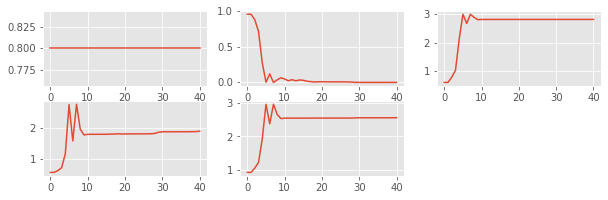

In [14]:
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.subplot(531+i)
    D1 = list(map(lambda s:s[i], Ds))
    print(D1)
    plt.plot(D1)

[1.0, 2.993352547092347, 0.0009100644279844954, 0.006035943188599747, 0.007664383423627971]


Text(0.5, 1.0, 'Decay rates')

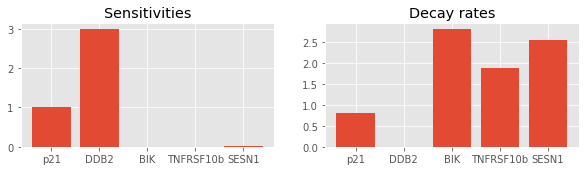

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
S = [s.numpy() for s in model.kernel.S]
D = [d.numpy() for d in model.kernel.D]
print(S)
plt.bar(range(5), S, tick_label=genes.index[:-1])
plt.title('Sensitivities')
plt.subplot(2, 2, 2)
plt.bar(range(5), D, tick_label=genes.index[:-1])
plt.title('Decay rates')

In [298]:
pred_t = np.linspace(0, 12, 20)
k = model.kernel

K_inv = tf.linalg.inv(k.K(X, None))
Kxf = k.K(X, X)

B = np.ones(5)
print('b/d = ', np.repeat(B/np.array(D), 7).reshape(-1, 1).shape, Y.shape)
x = tf.convert_to_tensor(Y) - np.repeat(B/np.array(D), 7).reshape(-1, 1)
print(x.shape)
KfxKxx = tf.matmul(tf.transpose(Kxf), K_inv)
mu_post = tf.matmul(KfxKxx, x)
# print(KfxKxx, Y)
print(tf.transpose(Kxf).shape, '*', K_inv.shape,'==', KfxKxx.shape, '*', x.shape)
print('mu shape', mu_post.shape)

Kff = k.K_diag(X)
# K_post = Kff - KfxKxx * Kxf
# print('K shape', K_post.shape)

K not none K_xf

b/d =  (35, 1) (35, 1)
(35, 1)
(7, 35) * (35, 35) == (7, 35) * (35, 1)
mu shape (7, 1)
k_diag


(7,)
12
range [0.] 0
sum [0.0]
range [0. 2.] 2
sum [0.0, 2.246340235898232e+16]
range [0. 2. 4.] 4
sum [0.0, 2.246340235898232e+16, 2.1451389836269616e+17]
range [0. 2. 4. 6.] 6
sum [0.0, 2.246340235898232e+16, 2.1451389836269616e+17, 1.538612081526223e+18]
range [0. 2. 4. 6. 8.] 8
sum [0.0, 2.246340235898232e+16, 2.1451389836269616e+17, 1.538612081526223e+18, 8.174543144671643e+18]
range [ 0.  2.  4.  6.  8. 10.] 10
sum [0.0, 2.246340235898232e+16, 2.1451389836269616e+17, 1.538612081526223e+18, 8.174543144671643e+18, 4.105084963264032e+19]
range [ 0.  2.  4.  6.  8. 10. 12.] 12
sum [0.0, 2.246340235898232e+16, 2.1451389836269616e+17, 1.538612081526223e+18, 8.174543144671643e+18, 4.105084963264032e+19, 2.039156181194434e+20]


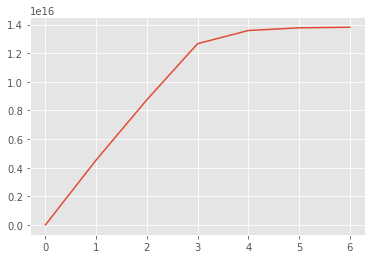

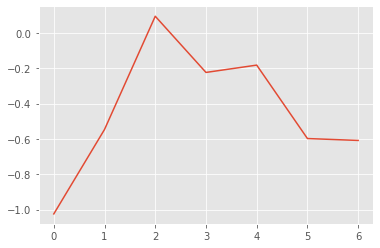

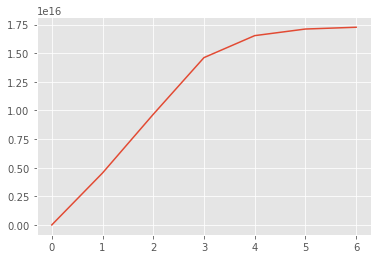

In [299]:
mu = mu_post.numpy().reshape(-1)
print(mu.shape)
plt.plot(mu[:7])
plt.figure()
plt.plot(Y[:7])
plt.figure()

ts = np.arange(7)*2
print(t)
x_1 = list()
for t in ts:
    print('range', np.arange(t/2+1)*2, t)
    print('sum', [mu[int(t_/2)]*np.exp(k.D[0]*t_) for t_ in np.arange(t/2+1)*2])
    x_1.append(k.S[0]*np.exp(-k.D[0]*t)*np.sum([mu[int(t_/2)]*np.exp(k.D[0]*t_) for t_ in np.arange(t/2+1)*2]))
plt.plot(x_1)

In [119]:
mean, var = model.predict_f(X)
mean

(35, 35)
k_diag
K not none K_xf

err shape (35, 35)


InvalidArgumentError: Incompatible shapes: [35] vs. [7] [Op:Sub] name: sub/

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(mean)
plt.subplot(2, 2, 2)
plt.plot(genes[genes.index == 'p53'].values[0])

## Non-linear response
    